In [463]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize
from scipy.stats import norm
from astropy.io import ascii
from astropy.table import Table, vstack
import pandas as pd
from astropy import modeling

from astropy.modeling import models
from astropy import units as u

from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_lines,fit_generic_continuum,fit_continuum

#Helper functions and data setup

txt_table = pd.read_csv('./Pair Production/gamma_data.txt',delim_whitespace=True,header=17)
txt_table.columns = ['ch1', 'dat1',
                    'ch2', 'dat2',
                    'ch3', 'dat3',
                    'ch4', 'dat4',
                    'ch5', 'dat5',
                    'ch6', 'dat6',
                    'ch7', 'dat7',
                    'ch8', 'dat8',
                    'ch9', 'dat9',
                    'ch10', 'dat10',
                    'ch11', 'dat11',
                    'ch12', 'dat12',
                    'ch13', 'dat13',
                    'ch14', 'dat14',
                    'ch15', 'dat15',
                    'ch16', 'dat16',
                    'ch17', 'dat17',
                    'ch18', 'dat18']
summary_data = Table.from_pandas(txt_table)

summary_data['dat2'] = 6*summary_data['dat2']

#Calibration data: Impacts only x-axis, which are all the same! So set up a "calx" array scaled between calibration points

caldb = [[1107.85,1887.81,2141.89],[0.662,1.137,1.3325]]
calx = []

for inx in summary_data['ch2']:
    if inx < caldb[0][0]:
        calx.append(inx*(caldb[1][0]/caldb[0][0]))
    elif inx < caldb[0][1]:
        calx.append((inx-caldb[0][0])*((caldb[1][1]-caldb[1][0])/(caldb[0][1]-caldb[0][0]))+caldb[1][0])
    elif inx < caldb[0][2]:
        calx.append((inx-caldb[0][1])*((caldb[1][2]-caldb[1][1])/(caldb[0][2]-caldb[0][1]))+caldb[1][1])
    elif inx >= caldb[0][2]:
        calx.append((inx-caldb[0][2])*((caldb[1][2]-caldb[1][1])/(caldb[0][2]-caldb[0][1]))+caldb[1][2])
        
bkg_x = np.array(calx)#summary_data['ch2'])

#This data is really noisy; so I rebin it in bins of 4096/512 = 8 columns each.

multi = 4
bins = 512*multi

def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

#Plot function and fit gamma

#def gamma_func(x,a,λ,σ):
#    if (x <= -(σ**2)/λ):
#        return a*np.e**(x/λ+(σ**2)/(2*λ**2))
#    else:
#        return a*np.e**(-(x**2)/(2*σ**2))

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

def quadratic(x,x0,a,b):
    return (a*(x-x0)**2+b)

def plot_minus_background(ydata,bgdata,title="",fit=False):
    bkg_y = np.array(bgdata)
    bkg_xy = np.array([bkg_x,bkg_y])

    bkg_xy = rebin(bkg_xy,(2,bins))

    rad_x = np.array(calx)#summary_data['ch1'])
    rad_y = ydata
    rad_xy = np.array([rad_x,rad_y])
    binned_radxy = rebin(rad_xy,(2,bins))

    binned_radx = binned_radxy[0]
    binned_rady = binned_radxy[1] - bkg_xy[1]
    binned_radxy_bs = np.array([binned_radx,binned_rady])

    fig1=plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
    plt.plot(bkg_xy[0],bkg_xy[1],'-',lw=1,color='blue',alpha=0.4,label="background")
    plt.plot(binned_radxy[0],binned_radxy[1],'-',lw=1,color='red',alpha=0.4,label="Counts w/bg")
    plt.plot(binned_radxy_bs[0],binned_radxy_bs[1],'-',lw=1,color='red',label="Counts (bg subtracted)")
    if fit:
        st = 101*multi
        en = 116*multi
        #xs = binned_radxy_bs[0][st:en]-np.mean(binned_radxy_bs[0][st:en])
        
        spectrum = Spectrum1D(flux=binned_radxy_bs[1]*u.ct,spectral_axis=binned_radxy_bs[0]*u.MeV)
        g_init = models.Gaussian1D(amplitude=1100.*u.ct, mean=0.551*u.MeV, stddev=0.0025*u.MeV)
        g_fit = fit_lines(spectrum, g_init)
        y_fit = g_fit(binned_radxy_bs[0]*u.MeV)
        
        g1_fit = fit_generic_continuum(spectrum)
        y_continuum_fitted = g1_fit(binned_radxy_bs[0]*u.MeV)
        
        plt.plot(binned_radxy_bs[0],y_fit)
        plt.plot(binned_radxy_bs[0],y_continuum_fitted)
        
        #popt, _ = optimize.curve_fit(gaussian,xs,binned_radxy_bs[1][st:en],p0=[1100,0,0.0025])
        #plt.plot(xs+np.mean(binned_radxy_bs[0][st:en]),gaussian(xs,*popt))
        
    plt.title(title,fontsize=16)
    plt.xlabel('Energy (MeV)',fontsize=16)
    plt.ylabel('Counts',fontsize=16)
    plt.axvline(0.662,alpha=0.3,label="calibration points")
    plt.axvline(1.137,alpha=0.3)
    plt.axvline(1.3325,alpha=0.3)
    plt.axvline(0.511,color="black",alpha=0.6,label="511 keV")
    plt.axvline(bkg_xy[0*multi][101*multi],color="black",alpha=0.3)
    plt.axvline(bkg_xy[0*multi][116*multi],color="black",alpha=0.3)
    if fit: plt.xlim(0.4,0.65)
    plt.legend(loc=1)





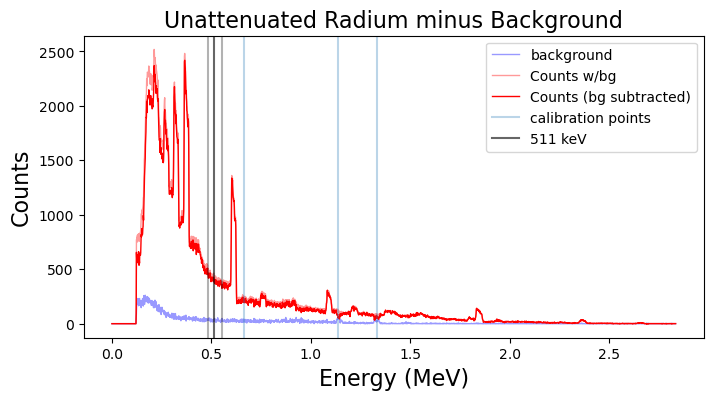

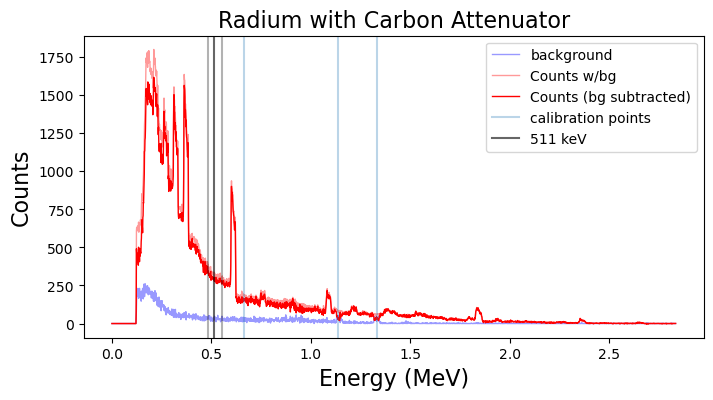

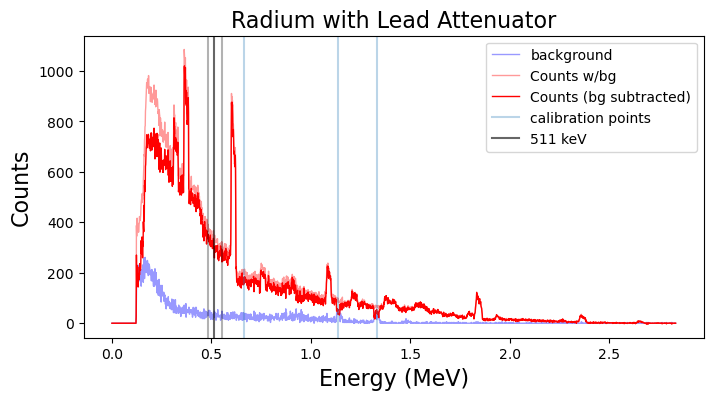

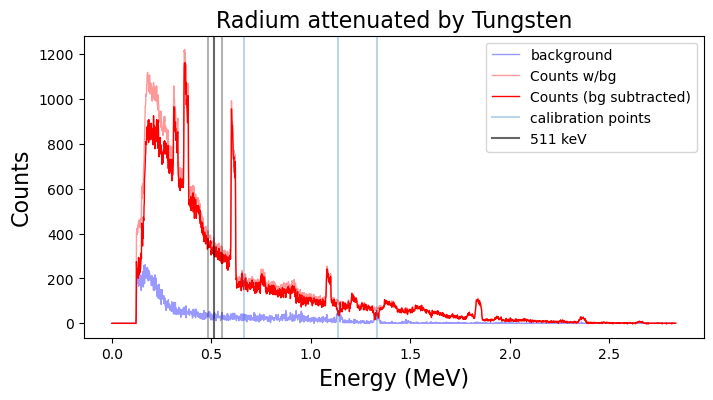

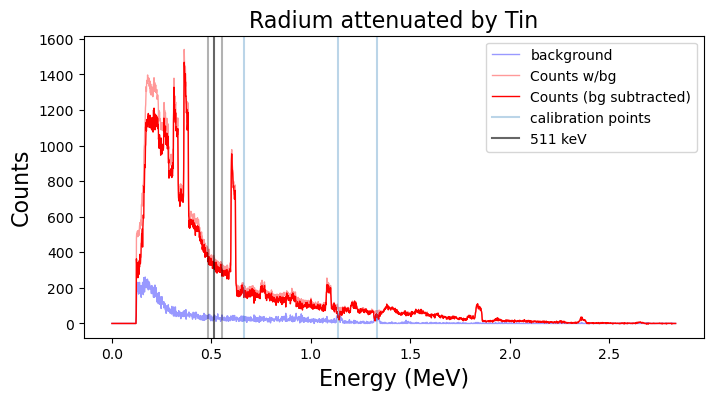

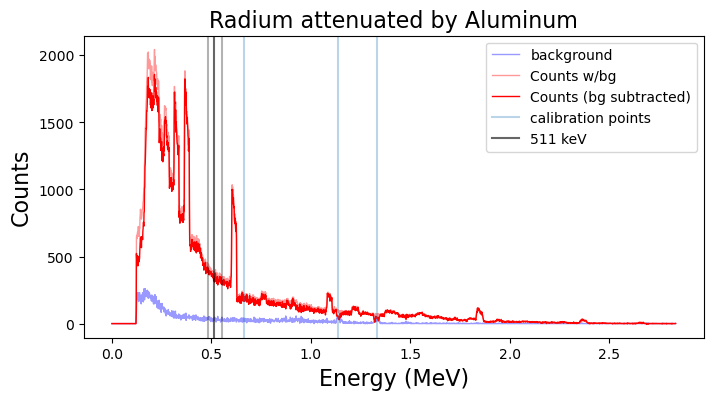

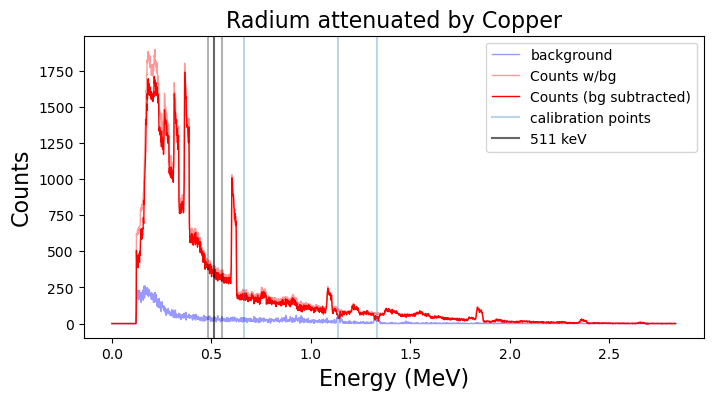

In [464]:
#Unattenuated Radium
plot_minus_background(np.array(summary_data['dat1']),summary_data['dat2'],title='Unattenuated Radium minus Background')

#Radium with Carbon Attenuator
plot_minus_background(np.array(summary_data['dat3']),summary_data['dat2'],title='Radium with Carbon Attenuator')

#Radium with Lead Attenuator
plot_minus_background(np.array(summary_data['dat4']),summary_data['dat2'],title='Radium with Lead Attenuator')

#Radium attenuated by Tungsten
plot_minus_background(np.array(summary_data['dat15']),summary_data['dat2'],title='Radium attenuated by Tungsten')

#Radium attenuated by Tin
plot_minus_background(np.array(summary_data['dat16']),summary_data['dat2'],title='Radium attenuated by Tin')

#Radium attenuated by Aluminum
plot_minus_background(np.array(summary_data['dat17']),summary_data['dat2'],title='Radium attenuated by Aluminum')

#Radium attenuated by Copper
plot_minus_background(np.array(summary_data['dat18']),summary_data['dat2'],title='Radium attenuated by Copper')

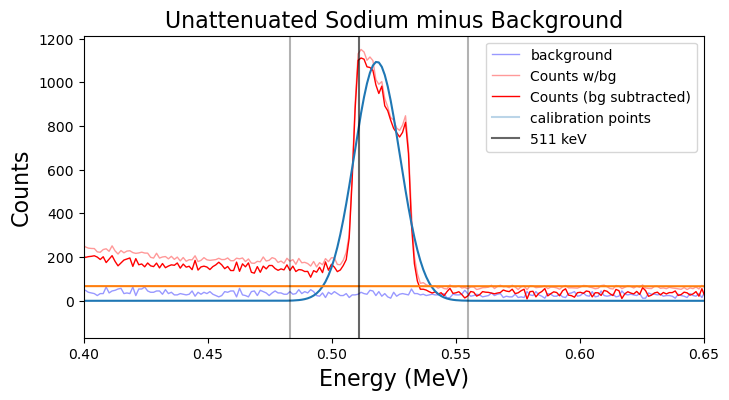

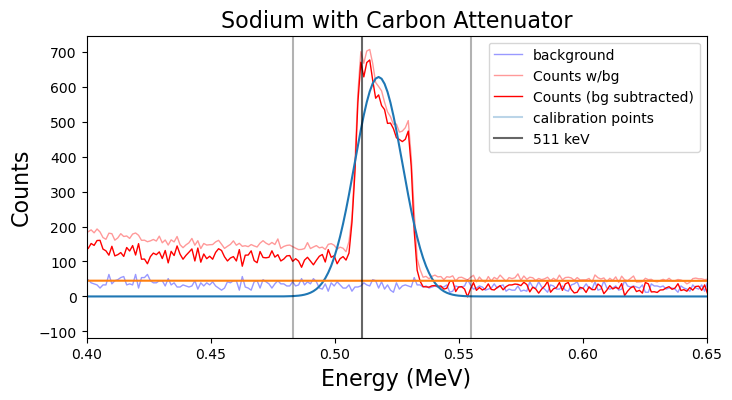

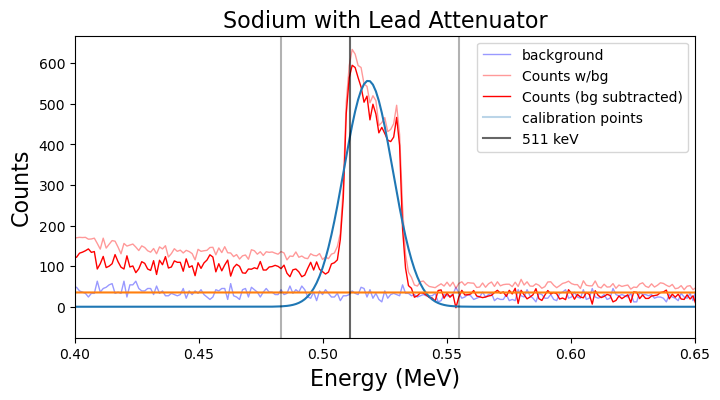

In [465]:
#Unattenuated Sodium
plot_minus_background(np.array(summary_data['dat5']),summary_data['dat2'],title='Unattenuated Sodium minus Background',fit=True)

#Sodium with Carbon Attenuator
plot_minus_background(np.array(summary_data['dat7']),summary_data['dat2'],title='Sodium with Carbon Attenuator',fit=True)

#Sodium with Lead Attenuator
plot_minus_background(np.array(summary_data['dat6']),summary_data['dat2'],title='Sodium with Lead Attenuator',fit=True)

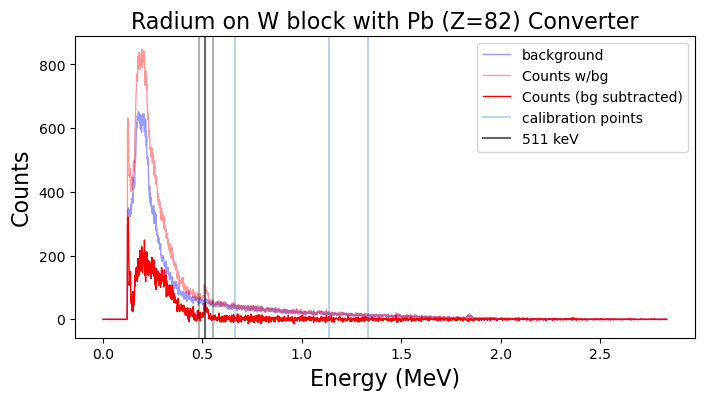

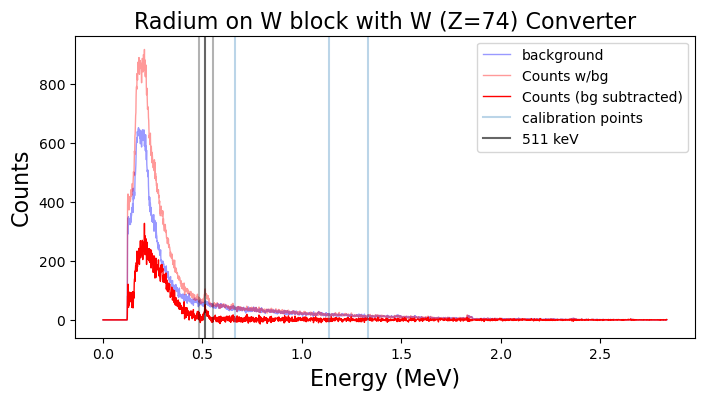

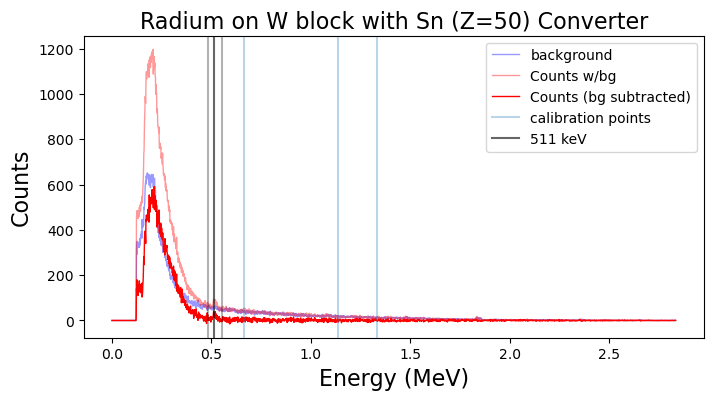

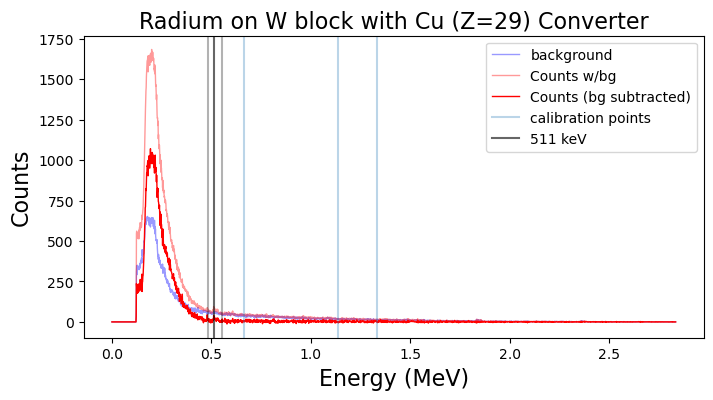

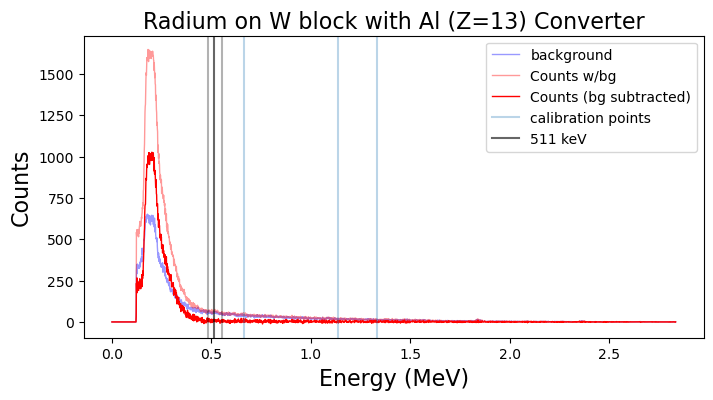

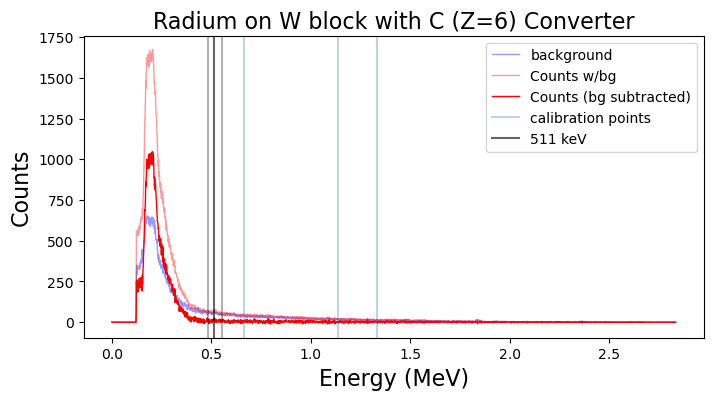

In [466]:
#Pair Production, Lead
plot_minus_background(np.array(summary_data['dat8']),summary_data['dat14'],title='Radium on W block with Pb (Z=82) Converter')

#Pair Production, Tungsten
plot_minus_background(np.array(summary_data['dat9']),summary_data['dat14'],title='Radium on W block with W (Z=74) Converter')

#Pair Production, Tin
plot_minus_background(np.array(summary_data['dat10']),summary_data['dat14'],title='Radium on W block with Sn (Z=50) Converter')

#Pair Production, Copper
plot_minus_background(np.array(summary_data['dat11']),summary_data['dat14'],title='Radium on W block with Cu (Z=29) Converter')

#Pair Production, Aluminum
plot_minus_background(np.array(summary_data['dat12']),summary_data['dat14'],title='Radium on W block with Al (Z=13) Converter')

#Pair Production, Carbon
plot_minus_background(np.array(summary_data['dat13']),summary_data['dat14'],title='Radium on W block with C (Z=6) Converter')
